In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import os
from pathlib import Path

import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [2]:
positive_dir = Path('../input/surface-crack-detection/Positive')

negative_dir = Path('../input/surface-crack-detection/Negative')

In [3]:
def generate_df(image_dir, label) :
    
    filepaths = pd.Series(list(image_dir.glob(r'*.jpg')), name='Filepath').astype(str)
    lables = pd.Series(label, name='Label', index=filepaths.index)
    df = pd.concat([filepaths, lables], axis=1)
    return df

In [4]:
positive_df = generate_df(positive_dir, label="CRACK")
negative_df = generate_df(negative_dir, label='CLEAN')
df = pd.concat([positive_df, negative_df], axis=0).reset_index(drop=True)

df

,Filepath,Label
0,../input/surface-crack-detection/Positive/0845...,CRACK
1,../input/surface-crack-detection/Positive/1981...,CRACK
2,../input/surface-crack-detection/Positive/0593...,CRACK
3,../input/surface-crack-detection/Positive/0612...,CRACK
4,../input/surface-crack-detection/Positive/0853...,CRACK
...,...,...
39995,../input/surface-crack-detection/Negative/1897...,CLEAN
39996,../input/surface-crack-detection/Negative/1698...,CLEAN
39997,../input/surface-crack-detection/Negative/0913...,CLEAN
39998,../input/surface-crack-detection/Negative/1003...,CLEAN


In [29]:
import cv2
images = [cv2.imread(i, 0) for i in df["Filepath"]]

In [25]:
image_test = cv2.imread(df["Filepath"][5])

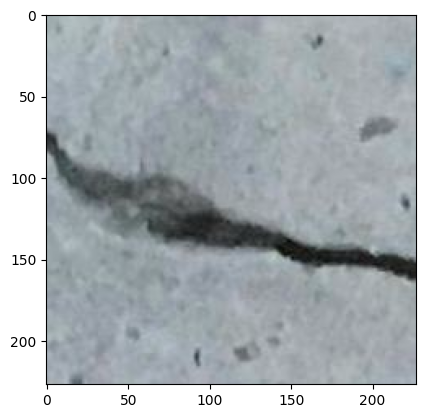

In [28]:
plt.imshow(image_test)

array([[212, 220, 227, ..., 161, 164, 163],
       [218, 218, 219, ..., 153, 158, 161],
       [222, 222, 222, ..., 142, 152, 158],
       ...,
       [179, 182, 183, ..., 190, 190, 191],
       [180, 183, 183, ..., 187, 187, 188],
       [182, 185, 184, ..., 183, 184, 185]], dtype=uint8)

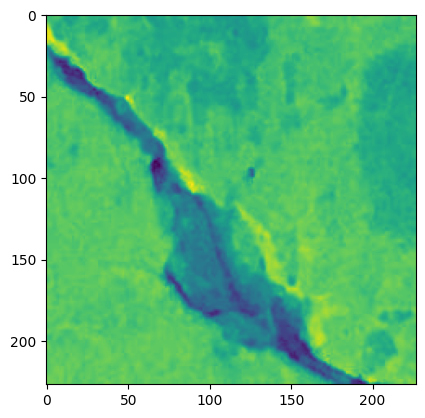

In [30]:
plt.imshow(images[500])
images[200]

In [31]:
from numpy import floor, exp, power, arange, reshape

def filtre_gaussien(N=512, s=0.01):
    """Define a bi-dimensional N-periodic Gaussian kernel.
    
    Parameters
        ----------
    N : int
        image size. The default is 512.
    s : positive float, optional
        scale parameter. The default is 1.

   Returns

    -------

    The Gaussian kernel

    """

    M = floor(N / 2)
    # Definition of an bidimensional Gaussian kernel.

    g = exp(- s * power(arange(- M, M+1, 1), 2)).reshape((N, 1))
    G = np.dot(g, g.T)
    Z = sum(G)
    return(G/Z)

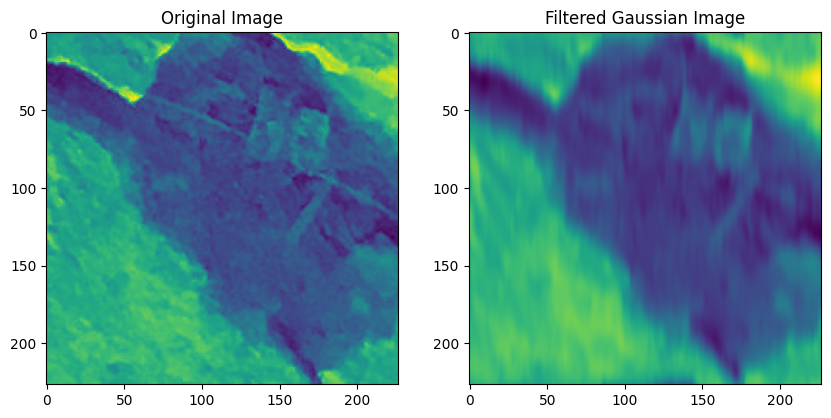

In [32]:
from numpy.fft import fft2, ifft2, fftshift

# Assuming you have your surface crack detection image in the variable 'image'

# and you have the transfer function g^ generated by the filtre_gaussien function.

# Perform Fourier Transform on the image

image_fft = fft2(images[14])

# Make sure the transfer function has the same shape as the image

transfer_function = filtre_gaussien(N=images[24510].shape[0], s=0.01)

# Shift the transfer function to place the pixel at n=[0,0] to the index (0, 0)

shifted_transfer_function = fftshift(transfer_function)

# Apply the filter in the frequency domain

filtered_image_fft = image_fft * shifted_transfer_function

# Perform Inverse Fourier Transform to get the filtered image

filtered_image = np.abs(ifft2(filtered_image_fft))

# Display the original and filtered images

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(images[14])
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(filtered_image)
plt.title('Filtered Gaussian Image')
plt.show()

In [33]:
def gaussian_filter(N, s):

    n = np.arange(-N//2, N//2)
    n1, n2 = np.meshgrid(n, n)  # Création des repères pour représenter l'image
    g = np.exp(-s * (np.power(n1, 2) + np.power(n2, 2)))
    Z = np.sum(g)
    return g / Z



def derivative_filters(N, s):
    n = np.arange(-N//2, N//2)
    n1, n2 = np.meshgrid(n, n)
    g = gaussian_filter(N, s)
    print(n1.shape, g.shape)
    dj1 = 1j * n1 * g  # dérivée spatiale
    dj2 = 1j * n2 * g
    print(dj1.shape)
    return dj1, dj2



def laplacian_filter(N, s):
    
    n = np.arange(-N//2, N//2)
    n1, n2 = np.meshgrid(n, n)
    g = gaussian_filter(N, s)
    delta = - (n1**2 + n2**2) * g
    return delta

(227, 227) (227, 227)
(227, 227)


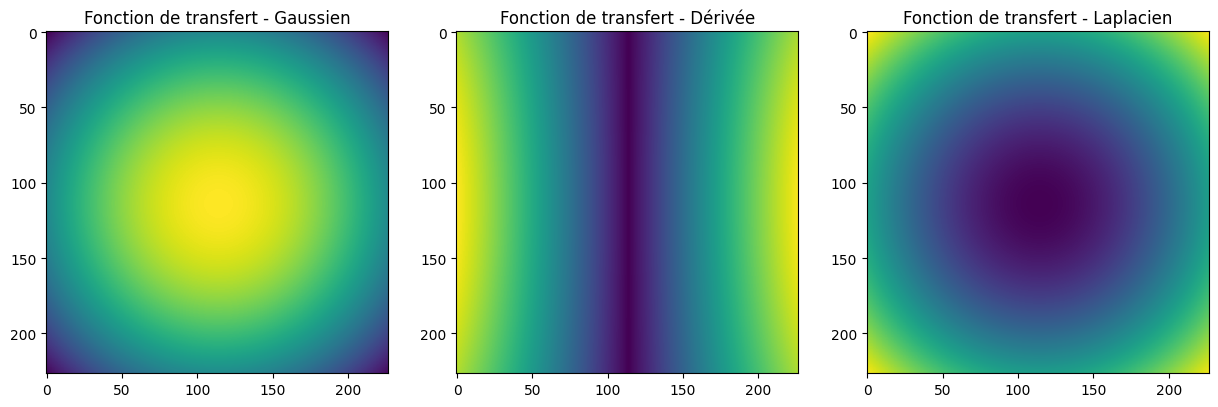

In [34]:
#visualisation des fonctions de transfert

# Paramètres

shape_image = 227

s = 0.00001

# Filtres

gaussian = gaussian_filter(N=shape_image, s=s)
derivative_x, derivative_y = derivative_filters(N=shape_image, s=s)
laplacian = laplacian_filter(N=shape_image, s=s)

# Affichage

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(gaussian, cmap='viridis')
plt.title('Fonction de transfert - Gaussien')
plt.subplot(1, 3, 2)
plt.imshow(np.abs(derivative_x), cmap='viridis')
plt.title('Fonction de transfert - Dérivée')
plt.subplot(1, 3, 3)
plt.imshow(np.abs(laplacian), cmap='viridis')
plt.title('Fonction de transfert - Laplacien')
plt.show()

## Interprétation des filtres associés aux fonctions de transfert. Il est essentiel de comprendre le rôle de chaque fonction de transfert et ce qu'elle représente en termes de traitement d'image.



1. **Fonction de Transfert Gaussienne, $\hat{g}[n]$**:

   La fonction de transfert Gaussienne est un filtre lissant. Elle sert principalement à flouter l'image, réduire le bruit et préparer l'image pour des opérations subséquentes. En termes de fréquence, elle est un filtre passe-bas, car elle laisse passer les basses fréquences (représentant les grandes structures ou variations lentes dans l'image) tout en atténuant les hautes fréquences (représentant les détails fins ou le bruit).



2. **Fonctions de Transfert Dérivées, $\hat{\partial}_jg[n]$ pour $j = 1, 2$**:

   Ces fonctions sont les dérivées partielles de la fonction de transfert Gaussienne selon les deux dimensions. Elles sont proportionnelles à la dérivée du filtre Gaussien. En traitement d'image, la dérivation est utilisée pour la détection de bords. Ces filtres vont donc mettre en évidence les variations rapides d'intensité dans l'image, ce qui correspond généralement aux bords ou contours. En termes de fréquence, ils peuvent être considérés comme des filtres passe-haut car ils mettent en évidence les détails fins (hautes fréquences).



3. **Fonction de Transfert Laplacienne, $\hat{\Delta}g[n]$**:

   Cette fonction est proportionnelle à la seconde dérivée du filtre Gaussien. La seconde dérivation, ou le laplacien, est souvent utilisée pour détecter les régions où l'intensité de l'image change brusquement dans toutes les directions, ce qui peut correspondre à des contours. Cette fonction de transfert mettra donc en évidence les zones de l'image où il y a un changement brusque d'intensité. Elle peut être interprétée comme un filtre détecteur de bord ou un filtre passe-bande car elle laisse passer certaines fréquences tout en atténuant d'autres.



**En résumé**:

- $\hat{g}[n]$ est un filtre passe-bas.

- $\hat{\partial}_jg[n]$ (pour $j = 1, 2$) sont des filtres passe-haut.

- $\hat{\Delta}g[n]$ est un filtre détecteur de bord, souvent interprété comme un filtre passe-bande.



Chacun de ces filtres met en évidence ou atténue différentes caractéristiques de l'image, et ils sont essentiels pour la détection de contours.

(227, 227) (227, 227)
(227, 227)


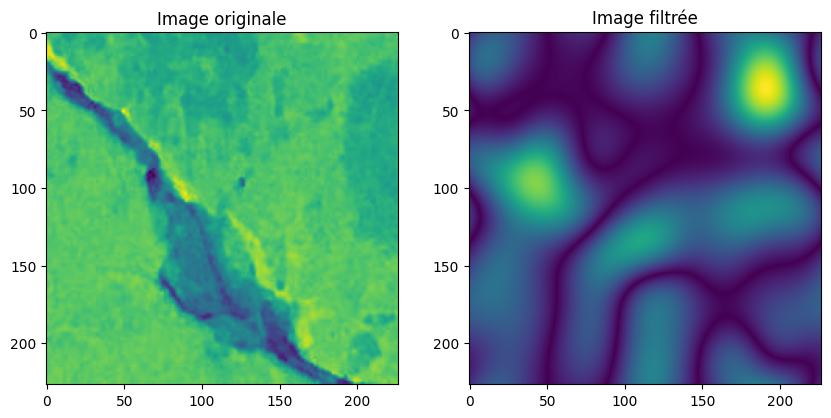

In [41]:
# Effectuer la transformation de Fourier sur l'image

image_index = 500
image_fft = fft2(images[image_index])

# Appliquer le filtre dérivatif dans le domaine fréquentiel

dj1, dj2 = derivative_filters(N=images[image_index].shape[0], s=0.0015)
dj1_fft = fft2(dj1)
dj2_fft = fft2(dj2)
filtered_image_fft = image_fft * (dj1_fft+dj2_fft)

# Effectuer la transformation de Fourier inverse pour obtenir l'image filtrée

filtered_image = np.abs(ifft2(filtered_image_fft))

# Afficher l'image originale et l'image filtrée

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(images[image_index])
plt.title('Image originale')
plt.subplot(1, 2, 2)
plt.imshow(filtered_image)
plt.title('Image filtrée')
plt.show()

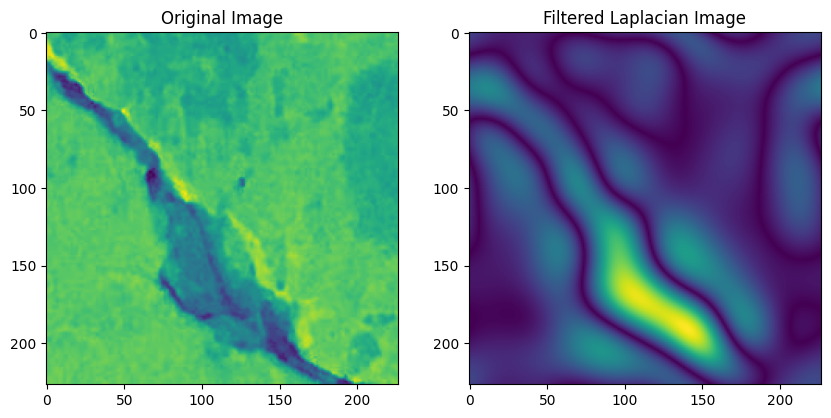

In [50]:
index_image = 500
shape_image = images[index_image].shape[0]
image_fft = fft2(images[index_image])

# Make sure the transfer function has the same shape as the image

transfer_function = laplacian_filter(N=images[index_image].shape[0], s=0.125)

# Shift the transfer function to place the pixel at n=[0,0] to the index (0, 0)

shifted_transfer_function = fftshift(transfer_function)

# Apply the filter in the frequency domain

filtered_image_fft = image_fft * shifted_transfer_function

# Perform Inverse Fourier Transform to get the filtered image

filtered_image = np.abs(ifft2(filtered_image_fft))

# Display the original and filtered images

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(images[index_image])
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(filtered_image)
plt.title('Filtered Laplacian Image')
plt.show()

On voit ici que la faille est contourée, malgré un ajustement du paramètre du filtre de transfert celui-ci reste assez sensible au 
variation de couleur de la roche

(227, 227) (227, 227)
(227, 227)


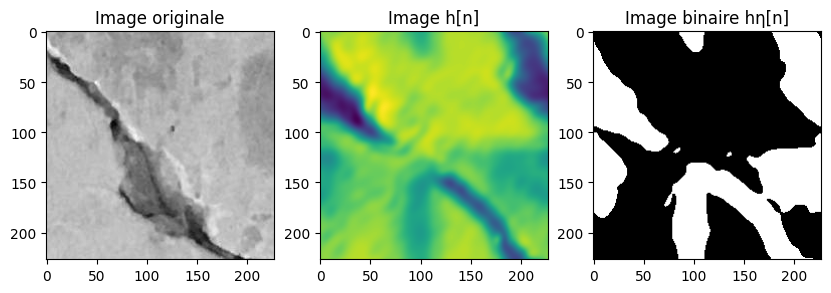

In [61]:
index_image = 500
f = images[index_image]
shape_image = images[index_image].shape[0]
image_fft = fft2(images[500])

#gaussian

gaussian = gaussian_filter(N=shape_image, s=0.00025)
shifted_gaussian = fftshift(gaussian)
image_fft_gaussian = image_fft * shifted_gaussian
filtered_image = ifft2(image_fft_gaussian)

#laplacian

laplacian = laplacian_filter(N=shape_image, s=0.125)
shifted_laplacian = fftshift(laplacian)
image_fft_laplacian = image_fft * shifted_laplacian
filtered_image2 = ifft2(image_fft_laplacian)

#derivative

dj1, dj2 = derivative_filters(N=images[image_index].shape[0], s=0.015)
dj1_fft = fft2(dj1)
dj2_fft = fft2(dj2)
dj1_fft= fftshift(dj1_fft)
dj2_fft= fftshift(dj2_fft)
image_fft_dj1 =image_fft*dj1_fft
image_fft_dj2 =image_fft*dj2_fft
image_fft_sum = image_fft * fftshift(dj1_fft+dj2_fft)
filtered_image_dj1 = ifft2(image_fft_dj1)
filtered_image_dj2 = ifft2(image_fft_dj2)
filtered_image_derivative = ifft2(image_fft_sum)

#g1 et g2

convolution_g1 = np.abs(filtered_image_derivative)**2
convolution_g2 = np.abs(filtered_image2)**2

# Former l'image h

h = convolution_g1 + convolution_g2

# Définir le seuil η

eta = h.mean()

# Seuiller l'image

h_eta = np.where(h > eta, 1, 0)

# Afficher les résultats

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(f, cmap='gray')
plt.title('Image originale')
plt.subplot(1, 3, 2)
plt.imshow(h, cmap='viridis')
plt.title('Image h[n]')
plt.subplot(1, 3, 3)
plt.imshow(h_eta, cmap='binary')
plt.title('Image binaire hη[n]')
plt.show()

In [57]:
h

array([[9300.87698868, 9467.96951253, 9731.6018978 , ..., 9590.49270196,
        9450.28772469, 9308.38482752],
       [9256.54113024, 9483.15607579, 9805.15661162, ..., 9535.11221342,
        9368.19888306, 9226.81135933],
       [9152.88274431, 9411.40184034, 9777.46689085, ..., 9458.68632667,
        9265.16974802, 9111.74267475],
       ...,
       [9258.23791681, 9236.15161284, 9308.42597871, ..., 9554.17089745,
        9487.52621149, 9364.47447731],
       [9280.05383143, 9304.07518378, 9431.1938672 , ..., 9600.22263415,
        9512.16589848, 9372.20506336],
       [9299.71607952, 9392.42969226, 9587.55549089, ..., 9614.02348304,
        9500.0933993 , 9354.80912074]])

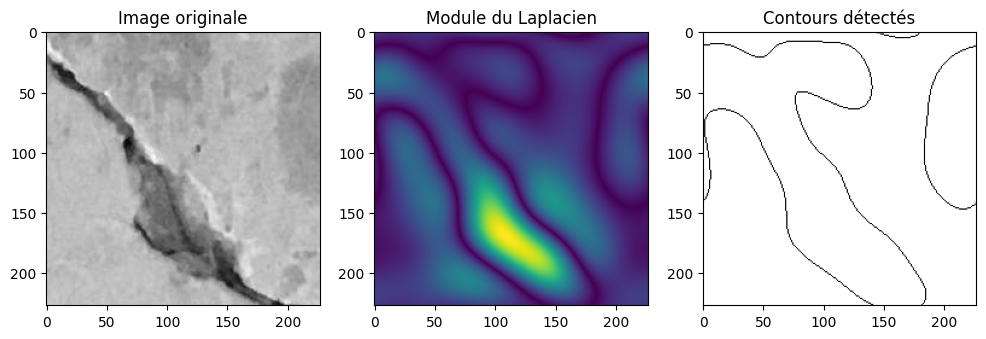

In [69]:
index_image = 500
image = images[index_image]
image_fft = fft2(image)

# Étape 1 : Calcul du Laplacien Δf

laplacian = laplacian_filter(N=shape_image, s=0.2)
shifted_laplacian = fftshift(laplacian)
image_fft_laplacian = image_fft * shifted_laplacian
laplacian_image = np.real(ifft2(image_fft_laplacian))

# Étape 2 : Détection des passages par zéro

def detect_zero_crossings(laplacian):
    sign_image = np.sign(laplacian)
    kernel = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
    k_tilde = convolve2d(sign_image, kernel, mode='same', boundary='symm')
    return k_tilde > 0

# Étape 3 : Détection des passages par zéro

zero_crossings = detect_zero_crossings(laplacian_image)

# Seuillage avec un seuil η

eta = -1 # À ajuster selon les besoins
edges = zero_crossings & (laplacian_image > eta)

# Affichage des résultats

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Image originale')
plt.subplot(1, 3, 2)
plt.imshow(np.abs(laplacian_image), cmap='viridis')
plt.title('Module du Laplacien')
plt.subplot(1, 3, 3)
plt.imshow(edges, cmap='binary')
plt.title('Contours détectés')



plt.show()


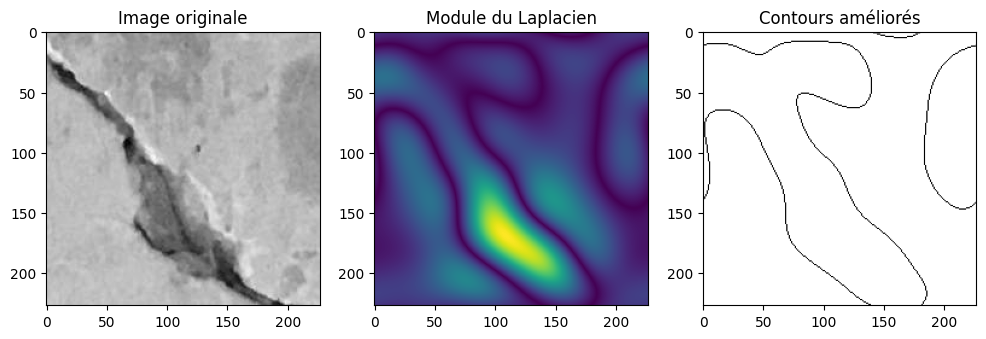

In [74]:
from scipy.ndimage import gaussian_filter

# Étape 0 : Filtrage Gaussien pour réduire le bruit
sigma = 5  # Écart-type du filtre gaussien
smoothed_image = gaussian_filter(image, sigma=sigma)

# Étape 1 : Calcul du Laplacien Δf (sur l'image lissée)
image_fft_smoothed = fft2(smoothed_image)
image_fft_laplacian = image_fft_smoothed * shifted_laplacian
laplacian_image = np.real(ifft2(image_fft_laplacian))

# Étape 2 : Détection des passages par zéro améliorée
def detect_zero_crossings_refined(laplacian, threshold):
    sign_image = np.sign(laplacian)
    kernel = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
    k_tilde = convolve2d(sign_image, kernel, mode='same', boundary='symm')
    zero_crossings = k_tilde > 0
    return zero_crossings & (laplacian > threshold)

# Ajustez le seuil
eta = -1  # Seuil ajusté
edges_refined = detect_zero_crossings_refined(laplacian_image, eta)

# Affichage des résultats
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Image originale')

plt.subplot(1, 3, 2)
plt.imshow(np.abs(laplacian_image), cmap='viridis')
plt.title('Module du Laplacien')

plt.subplot(1, 3, 3)
plt.imshow(edges_refined, cmap='binary')
plt.title('Contours améliorés')

plt.show()

# Classification | CNN

In [81]:
# Preprocess
from tensorflow.keras.utils import to_categorical

labels = np.array(["1"] * 20000 + ["0"] * 20000)
X = np.array(images[0:])
Y = labels.astype(int)

train_images, test_images, train_labels, test_labels = train_test_split(X, Y, train_size = 0.9, shuffle = True)

In [85]:
test_images.reshape(4000, 227, 227, 1)

test_images.shape

(4000, 227, 227)

In [92]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Créer un modèle CNN

model = Sequential([

    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(227, 227, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compiler le modèle

model.compile(optimizer='adam',

              loss='binary_crossentropy',

              metrics=['accuracy'])

model.summary()
# Entraîner le modèle

history = model.fit(train_images, train_labels, epochs=5, validation_data=(test_images, test_labels))


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)              │ (None, 225, 225, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 110, 110, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 55, 55, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 53, 53, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 179776)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │    11,505,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,561,537 (44.10 MB)

 Trainable params: 11,561,537 (44.10 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 20ms/step - accuracy: 0.8776 - loss: 21.8125 - val_accuracy: 0.9760 - val_loss: 0.0857
Epoch 2/5
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 20ms/step - accuracy: 0.9788 - loss: 0.0759 - val_accuracy: 0.9750 - val_loss: 0.1099
Epoch 3/5
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 20ms/step - accuracy: 0.9843 - loss: 0.0546 - val_accuracy: 0.9715 - val_loss: 0.0981
Epoch 4/5
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 20ms/step - accuracy: 0.9839 - loss: 0.0525 - val_accuracy: 0.9865 - val_loss: 0.0462
Epoch 5/5
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 20ms/step - accuracy: 0.9890 - loss: 0.2733 - val_accuracy: 0.9628 - val_loss: 0.1242


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

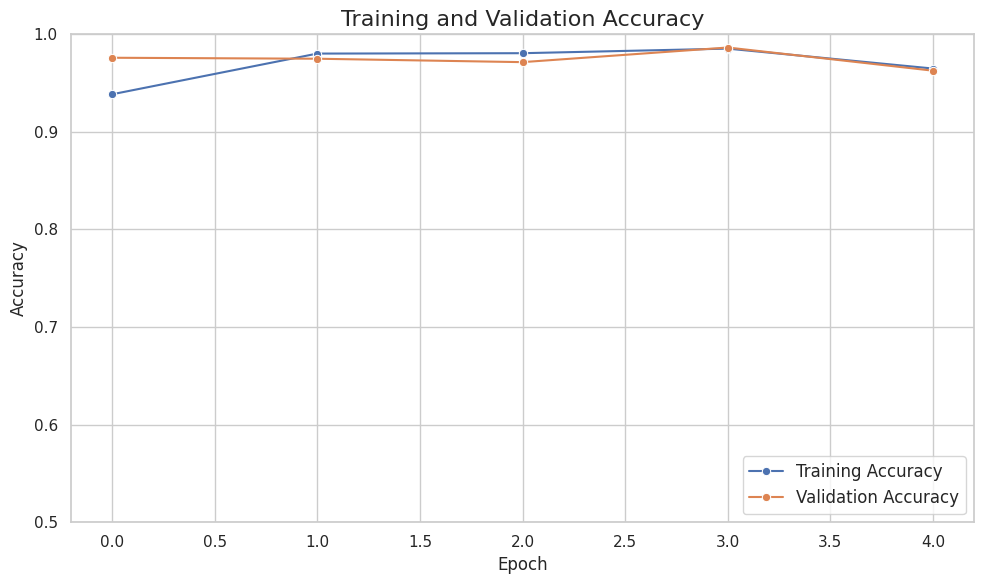

125/125 - 1s - 6ms/step - accuracy: 0.9628 - loss: 0.1242
Test accuracy: 0.9628


In [93]:
# Appliquer le style Seaborn
sns.set_theme(style="whitegrid")

# Créer la figure et les axes
plt.figure(figsize=(10, 6))

# Tracer les courbes d'accuracy
sns.lineplot(x=range(len(history.history['accuracy'])), 
             y=history.history['accuracy'], 
             label='Training Accuracy', 
             marker='o')

sns.lineplot(x=range(len(history.history['val_accuracy'])), 
             y=history.history['val_accuracy'], 
             label='Validation Accuracy', 
             marker='o')

# Ajouter des annotations et des limites
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Training and Validation Accuracy', fontsize=16)
plt.ylim([0.5, 1])
plt.legend(loc='lower right', fontsize=12)

# Afficher le graphique
plt.tight_layout()
plt.show()

# Évaluer le modèle
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f'Test accuracy: {test_acc:.4f}')


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


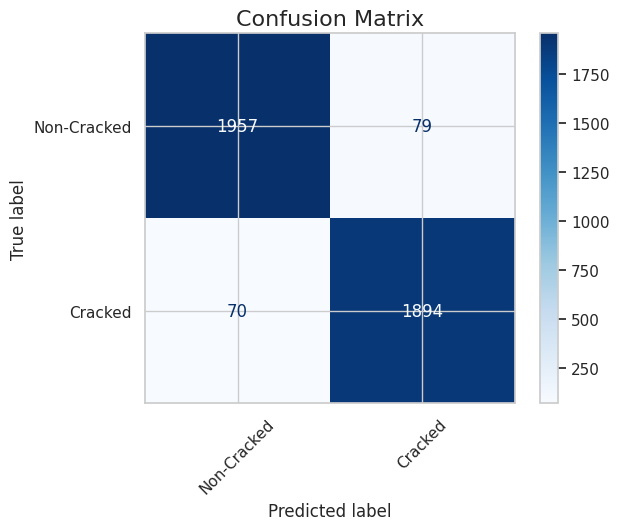

Classification Report:

              precision    recall  f1-score   support

 Non-Cracked       0.97      0.96      0.96      2036
     Cracked       0.96      0.96      0.96      1964

    accuracy                           0.96      4000
   macro avg       0.96      0.96      0.96      4000
weighted avg       0.96      0.96      0.96      4000



In [105]:
# Obtenir les prédictions du modèle sur les données de test
y_pred = model.predict(test_images)
y_pred_classes = y_pred.round()  # Convertir les probabilités en classes prédites
y_true = test_labels    # Classes réelles

# Matrice de confusion
conf_matrix = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Non-Cracked", "Cracked"])
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix", fontsize=16)
plt.show()

# Rapport de classification : précision, rappel, F1-score
class_report = classification_report(y_true, y_pred_classes, target_names=["Non-Cracked", "Cracked"])
print("Classification Report:\n")
print(class_report)

In [108]:
model.save("CNN_Crack_Detection.h5")
